# Classification - CIFAR10 (CNN)

### import

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import torch
import torch.nn as nn # class Model(nn.Module)
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms

In [ ]:
train_data = datasets.CIFAR10('./data', download = True, train = True, transform = transforms.ToTensor())
test_data = datasets.CIFAR10('./data', download = True, train = False, transform = transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Sample

In [ ]:
plt.imshow(train_data.data[0])

In [ ]:
train_data.data.shape # x: img

In [ ]:
# train_data.data[0] # Float: 0 ~ 255

In [ ]:
len(train_data.targets) # 0 ~ 9 : 10 class # list # int

In [ ]:
a = train_data.data
a.shape

In [ ]:
b = np.transpose(a, (0, 3, 1, 2))
b.shape

### Dataset -> DataLoader

In [ ]:
# train_data.data/ 255.

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data = train_data.data, label = train_data.targets):
        # 1) Float
        self.x = np.transpose(data / 255., (0, 3, 1, 2))
        self.y = label

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, index):
        x = self.x[index] # x: [3, 32, 32]
        y = self.y[index] # y: () or 1
        # return x, y
        return torch.tensor(x, dtype = torch.float), torch.tensor(y, dtype = torch.long)

In [ ]:
ds = MyDataset()
data = next(iter(ds))
data[0].shape, data[1].shape

(torch.Size([3, 32, 32]), torch.Size([]))

In [ ]:
def prepare_loaders(df = train_data.data, bs = 256):
    # train valid split
    train = df[:30000]
    valid = df[30000:]
    # train_ds, valid_ds
    train_ds = MyDataset(data=train, label=train_data.targets[:30000] )
    valid_ds = MyDataset(data=valid, label=train_data.targets[30000:] )
    # DataLoader
    train_loader = DataLoader(train_ds, batch_size = bs, shuffle = True)
    valid_loader = DataLoader(valid_ds, batch_size = bs, shuffle = False)
    print("Completed DataLoader")
    return train_loader, valid_loader

In [ ]:
train_loader, valid_loader = prepare_loaders()

Completed DataLoader


In [ ]:
data = next(iter(train_loader))
data[0].shape, data[1].shape

(torch.Size([256, 3, 32, 32]), torch.Size([256]))

### CNNModel

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        # input data's shape: [bs, 3, 32, 32]
        # conv
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels= 8, kernel_size = 3, stride = 1, padding = 1)
        #  [bs, 3, 32, 32] ->  [bs, 8, 32, 32]
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 7, stride = 1, padding =0)
        #  [bs, 8, 32, 32] ->  [bs, 16, 26, 26]
        self.pool = nn.MaxPool2d(2, 2)
        #  [bs, 16, 26, 26] -> [bs, 16, 13, 13]

        # [bs, 16, 13, 13] -> [bs, k] -> [bs, 64*4]
        k = 16* 13 * 13
        self.fc1= nn.Linear(k, 64*4)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64*4, 10)
        # nn.Softmax(dim=-1)
        # [bs, 64*4] -> [bs, 10]

    def forward(self, x):
        # 함수로 엮어주는 공간
        x = self.pool(self.conv2(self.conv1(x)))
        # x :[bs, 16, 13, 13] 

        # 1)
        x = torch.flatten(x, 1) # [bs, 16, 13, 13] -> [bs, k]
        # 2) 
        # x = x.reshape(x.shape[0], -1) # [bs, 16, 13, 13] -> [bs, k]

        y = self.fc(self.relu(self.fc1(x)))
        return y

In [ ]:
a = torch.randn(256, 16, 13, 13)
a.shape

In [ ]:
b = a.reshape(256, -1)
b.shape

In [ ]:
16*13*13

In [ ]:
model = CNNModel().to(device)
model

CNNModel(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2704, out_features=256, bias=True)
  (relu): ReLU()
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

### Lossfunction, Optimizer

In [ ]:
loss_fn = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())

### train_one_epoch

In [ ]:
# train_loss => 실시간 단위로 구할 예정
# accuracy => 실시간 단위로 구할 예정

from tqdm import tqdm
epoch = 1

def train_one_epoch(model = model, dataloader = train_loader, loss_fn = loss_fn, 
                    optimizer = optimizer, device = device, epoch = epoch):
    model.train()
    train_loss, dataset_size = 0,  0

    preds, trues = [], []

    bar = tqdm(dataloader, total = len(dataloader))
    for data in bar:
        x = data[0].to(device)      # x: [bs, 3, 32, 32]
        y_true = data[1].to(device) # y_true: [bs, 1]
        y_pred = model(x)           # y_pred: [bs, 10]
        y_pred = nn.LogSoftmax(dim = -1)(y_pred)
        loss = loss_fn(y_pred, y_true)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 실시간으로 train loss 
        # train_loss += loss.item()
    # train_loss / len(dataloader)

        bs = x.shape[0]
        dataset_size += bs # 실시간 크기 정보가 나옴 batch_size
        train_loss += (loss.item() * bs)
        train_loss /= dataset_size 

        # 실시간 Accuracy
        preds.append(y_pred) # preds: [ [bs, 10], [bs, 10], [bs, 10], ...]
        trues.append(y_true) # trues: [ [bs, 1], [bs, 1], [bs, 1], ...]

        # concat
        preds_cat = torch.cat(preds, dim = 0) # [total_bs, 10]
        trues_cat = torch.cat(trues, dim = 0) # [total_bs, 1]

        # (torch.argmax(preds_cat, dim =-1) == trues_cat).sum() # 전체 맞은 개수
        train_acc = 100*(torch.argmax(preds_cat, dim =-1) == trues_cat).sum().item() / dataset_size
        bar.set_description(f"Epoch{epoch:02d}|TL:{train_loss:.3e}|ACCURACY:{train_acc:.2f}")

    return train_loss, train_acc


In [ ]:
for epoch in range(10):
    train_loss = train_one_epoch(epoch = epoch)

Epoch00|TL:2.085e-03|ACCURACY:38.59: 100%|██████████| 118/118 [00:08<00:00, 13.68it/s]
Epoch01|TL:1.619e-03|ACCURACY:50.63: 100%|██████████| 118/118 [00:01<00:00, 63.94it/s]
Epoch02|TL:1.767e-03|ACCURACY:57.09: 100%|██████████| 118/118 [00:01<00:00, 60.35it/s]
Epoch03|TL:1.389e-03|ACCURACY:61.74: 100%|██████████| 118/118 [00:01<00:00, 59.68it/s]
Epoch04|TL:1.435e-03|ACCURACY:66.12: 100%|██████████| 118/118 [00:01<00:00, 61.94it/s]
Epoch05|TL:1.710e-03|ACCURACY:70.49: 100%|██████████| 118/118 [00:01<00:00, 62.35it/s]
Epoch06|TL:1.147e-03|ACCURACY:74.48: 100%|██████████| 118/118 [00:01<00:00, 62.80it/s]
Epoch07|TL:8.595e-04|ACCURACY:78.73: 100%|██████████| 118/118 [00:01<00:00, 63.42it/s]
Epoch08|TL:9.881e-04|ACCURACY:82.18: 100%|██████████| 118/118 [00:01<00:00, 60.65it/s]
Epoch09|TL:4.758e-04|ACCURACY:85.81: 100%|██████████| 118/118 [00:01<00:00, 63.37it/s]


### valid one epoch

In [ ]:
# train_loss => 실시간 단위로 구할 예정
# accuracy => 실시간 단위로 구할 예정

from tqdm import tqdm
epoch = 1

@torch.no_grad()
def valid_one_epoch(model = model, dataloader = valid_loader, loss_fn = loss_fn, 
                    device = device, epoch = epoch):
    model.eval()
    valid_loss, dataset_size = 0,  0

    preds, trues = [], []

    bar = tqdm(dataloader, total = len(dataloader))
    with torch.no_grad():
        for data in bar:
            x = data[0].to(device)      # x: [bs, 3, 32, 32]
            y_true = data[1].to(device) # y_true: [bs, 1]
            y_pred = model(x)           # y_pred: [bs, 10]
            y_pred = nn.LogSoftmax(dim = -1)(y_pred)
            loss = loss_fn(y_pred, y_true)

            bs = x.shape[0]
            dataset_size += bs # 실시간 크기 정보가 나옴 batch_size
            valid_loss += (loss.item() * bs)
            valid_loss /= dataset_size 

            # 실시간 Accuracy
            preds.append(y_pred) # preds: [ [bs, 10], [bs, 10], [bs, 10], ...]
            trues.append(y_true) # trues: [ [bs, 1], [bs, 1], [bs, 1], ...]

            # concat
            preds_cat = torch.cat(preds, dim = 0) # [total_bs, 10]
            trues_cat = torch.cat(trues, dim = 0) # [total_bs, 1]

            # (torch.argmax(preds_cat, dim =-1) == trues_cat).sum() # 전체 맞은 개수
            valid_acc = 100*(torch.argmax(preds_cat, dim =-1) == trues_cat).sum().item() / dataset_size
            bar.set_description(f"Epoch{epoch:02d}|VL:{valid_loss:.3e}|ACCURACY:{valid_acc:.2f}")

    return valid_loss, valid_acc


### Run Train

In [ ]:
def run_train(model = model, loss_fn = loss_fn, optimizer = optimizer, train_loader = train_loader, valid_loader = valid_loader):


    n_epochs = 120
    print_iter =10
    lowest_loss, lowest_epoch = np.inf, np.inf
    early_stop = 20
    train_hs, valid_hs = [],  [] # visualization
    train_accs, valid_accs = [],  [] # visualization
    for epoch in range(n_epochs):
        train_loss, train_acc = train_one_epoch(model = model, dataloader = train_loader, loss_fn = loss_fn, optimizer = optimizer, 
                                      device = device, epoch = epoch)
        valid_loss, valid_acc = valid_one_epoch(model = model, dataloader = valid_loader, loss_fn = loss_fn, 
                                      device = device, epoch = epoch)
        # 줍줍
        train_hs.append(train_loss)
        valid_hs.append(valid_loss)

        train_accs.append(train_acc)
        valid_accs.append(valid_acc)

        if (epoch + 1) % print_iter == 0:
            print()
            print(f"Ep:[{epoch:02d}]|TL:{train_loss:.4e}|VL:{valid_loss:.4e}|LL:{lowest_loss:.4e}|")
            print()
        # Lowest Loss 갱신 - valid_loss 기준
        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            lowest_epoch = epoch
            # model 저장
            torch.save(model.state_dict(), './model.bin') # pt, pth 
        
        else:
            if early_stop > 0 and lowest_epoch + early_stop < epoch + 1:
                print("넌 삽 질 중")
                break

    print()
    print("The Best Validation Loss=%.4e at %d Epoch" % (lowest_loss, lowest_epoch))

    # model load
    model.load_state_dict(torch.load('./model.bin'))


    result = dict()
    result["Train Loss"] = train_hs
    result["Valid Loss"] = valid_hs

    result["Train Acc"] = train_accs
    result["Valid Acc"] = valid_accs


    return result, model


In [ ]:
result, model = run_train()

Epoch00|TL:2.264e-03|ACCURACY:36.27: 100%|██████████| 118/118 [00:08<00:00, 14.54it/s]
Epoch00|VL:3.155e-03|ACCURACY:40.94: 100%|██████████| 79/79 [00:00<00:00, 92.06it/s]
Epoch01|TL:2.190e-03|ACCURACY:48.06: 100%|██████████| 118/118 [00:01<00:00, 64.08it/s]
Epoch01|VL:2.589e-03|ACCURACY:50.49: 100%|██████████| 79/79 [00:00<00:00, 91.57it/s]
Epoch02|TL:2.237e-03|ACCURACY:54.14: 100%|██████████| 118/118 [00:02<00:00, 58.11it/s]
Epoch02|VL:2.561e-03|ACCURACY:53.72: 100%|██████████| 79/79 [00:00<00:00, 90.49it/s]
Epoch03|TL:1.642e-03|ACCURACY:59.83: 100%|██████████| 118/118 [00:01<00:00, 61.42it/s]
Epoch03|VL:2.579e-03|ACCURACY:56.12: 100%|██████████| 79/79 [00:00<00:00, 85.69it/s]
Epoch04|TL:1.532e-03|ACCURACY:64.24: 100%|██████████| 118/118 [00:01<00:00, 60.41it/s]
Epoch04|VL:2.627e-03|ACCURACY:56.92: 100%|██████████| 79/79 [00:00<00:00, 83.77it/s]
Epoch05|TL:1.401e-03|ACCURACY:68.19: 100%|██████████| 118/118 [00:01<00:00, 62.45it/s]
Epoch05|VL:2.239e-03|ACCURACY:59.82: 100%|██████████|


Ep:[09]|TL:7.5246e-04|VL:2.0881e-03|LL:2.1122e-03|



Epoch10|TL:9.728e-04|ACCURACY:85.95: 100%|██████████| 118/118 [00:01<00:00, 60.78it/s]
Epoch10|VL:2.135e-03|ACCURACY:60.03: 100%|██████████| 79/79 [00:00<00:00, 89.64it/s]
Epoch11|TL:6.568e-04|ACCURACY:88.79: 100%|██████████| 118/118 [00:01<00:00, 59.39it/s]
Epoch11|VL:2.396e-03|ACCURACY:60.09: 100%|██████████| 79/79 [00:00<00:00, 89.55it/s]
Epoch12|TL:3.763e-04|ACCURACY:91.65: 100%|██████████| 118/118 [00:01<00:00, 62.50it/s]
Epoch12|VL:2.379e-03|ACCURACY:59.62: 100%|██████████| 79/79 [00:00<00:00, 93.84it/s]
Epoch13|TL:1.569e-04|ACCURACY:93.52: 100%|██████████| 118/118 [00:01<00:00, 61.70it/s]
Epoch13|VL:2.871e-03|ACCURACY:59.02: 100%|██████████| 79/79 [00:00<00:00, 87.06it/s]
Epoch14|TL:2.792e-04|ACCURACY:95.74: 100%|██████████| 118/118 [00:02<00:00, 53.64it/s]
Epoch14|VL:3.311e-03|ACCURACY:59.54: 100%|██████████| 79/79 [00:01<00:00, 64.54it/s]
Epoch15|TL:1.660e-04|ACCURACY:96.93: 100%|██████████| 118/118 [00:02<00:00, 51.95it/s]
Epoch15|VL:3.200e-03|ACCURACY:59.13: 100%|██████████|


Ep:[19]|TL:3.6736e-05|VL:5.1237e-03|LL:2.0881e-03|



Epoch20|TL:3.185e-05|ACCURACY:99.62: 100%|██████████| 118/118 [00:01<00:00, 62.66it/s]
Epoch20|VL:4.781e-03|ACCURACY:58.84: 100%|██████████| 79/79 [00:00<00:00, 91.28it/s]
Epoch21|TL:1.026e-05|ACCURACY:99.81: 100%|██████████| 118/118 [00:01<00:00, 62.97it/s]
Epoch21|VL:5.106e-03|ACCURACY:59.44: 100%|██████████| 79/79 [00:00<00:00, 85.53it/s]
Epoch22|TL:1.177e-05|ACCURACY:99.89: 100%|██████████| 118/118 [00:01<00:00, 60.68it/s]
Epoch22|VL:5.034e-03|ACCURACY:59.44: 100%|██████████| 79/79 [00:00<00:00, 92.05it/s]
Epoch23|TL:2.260e-05|ACCURACY:99.95: 100%|██████████| 118/118 [00:01<00:00, 60.36it/s]
Epoch23|VL:5.493e-03|ACCURACY:59.44: 100%|██████████| 79/79 [00:00<00:00, 91.82it/s]
Epoch24|TL:4.637e-05|ACCURACY:99.53: 100%|██████████| 118/118 [00:01<00:00, 62.08it/s]
Epoch24|VL:5.480e-03|ACCURACY:57.88: 100%|██████████| 79/79 [00:00<00:00, 83.33it/s]
Epoch25|TL:6.820e-04|ACCURACY:92.03: 100%|██████████| 118/118 [00:01<00:00, 62.95it/s]
Epoch25|VL:5.310e-03|ACCURACY:57.61: 100%|██████████|


Ep:[29]|TL:2.8681e-05|VL:4.7428e-03|LL:2.0881e-03|

넌 삽 질 중

The Best Validation Loss=2.0881e-03 at 9 Epoch


### Visualization

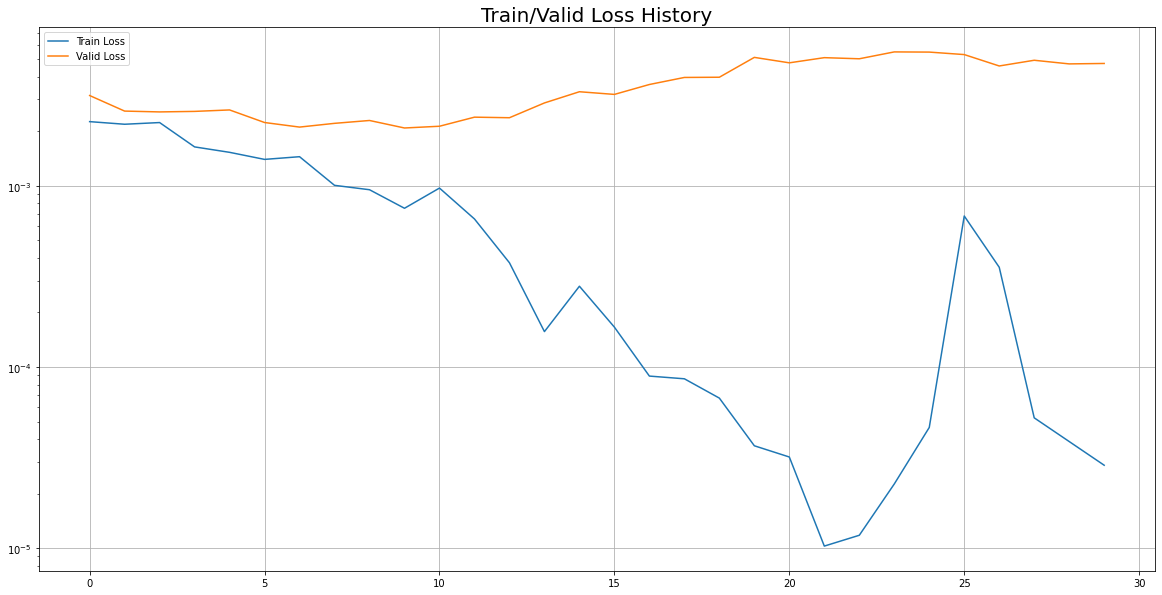

In [ ]:
## Train/Valid History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid Loss History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Loss'][plot_from:])), 
    result['Train Loss'][plot_from:], 
    label = 'Train Loss'
    )

plt.plot(
    range(0, len(result['Valid Loss'][plot_from:])), 
    result['Valid Loss'][plot_from:], 
    label = 'Valid Loss'
    )

plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

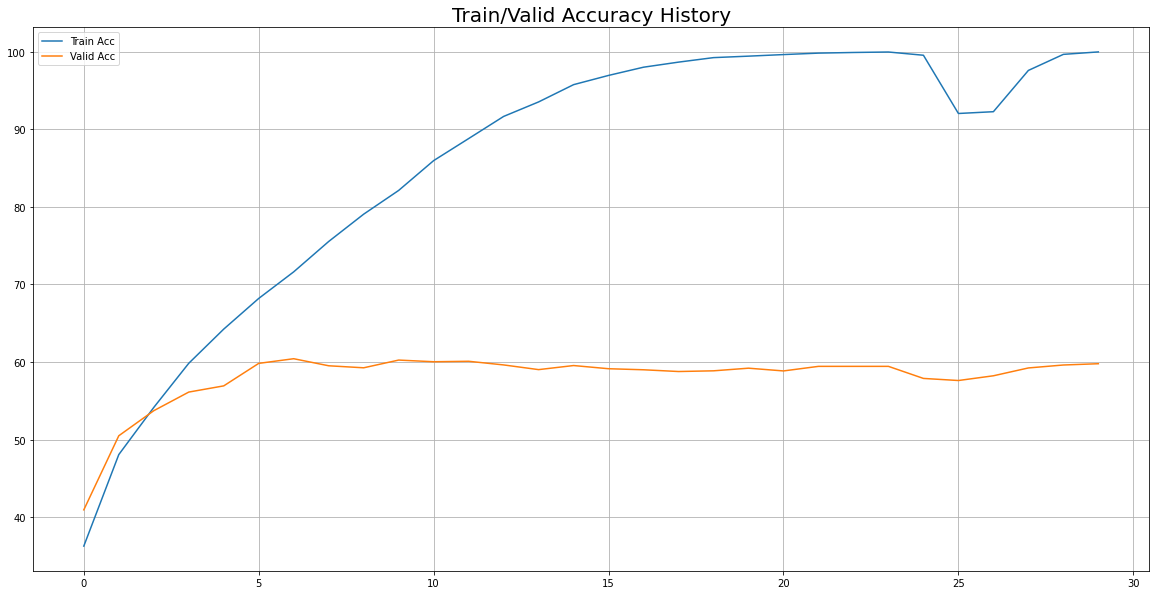

In [ ]:
# Train/Valid Accuracy
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid Accuracy History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Acc'])), 
    result['Train Acc'], 
    label = 'Train Acc'
    )

plt.plot(
    range(0, len(result['Valid Acc'])), 
    result['Valid Acc'], 
    label = 'Valid Acc'
    )

plt.legend()
# plt.yscale('log')
plt.grid(True)
plt.show()

## SAMPLE SIMULATION

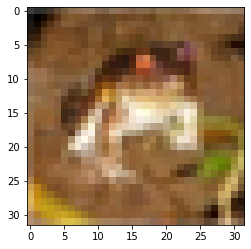

In [ ]:
plt.imshow(train_data.data[0])

In [ ]:
sample = torch.tensor(train_data.data[0], dtype = torch.float).permute(2, 0, 1).unsqueeze(0)

In [ ]:
sample.shape

torch.Size([1, 3, 32, 32])

In [ ]:
out = nn.Sequential(nn.Conv2d(3, 3, 3, 1, 1), nn.BatchNorm2d(3))(sample)
    # nn.BatchNorm(3)

out.shape

torch.Size([1, 3, 32, 32])

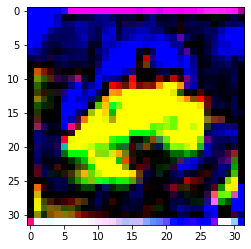

In [ ]:
plt.imshow(out.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())

In [ ]:
# RNN -> NLP 세호님 [진수님 끌리심] -> ㅣ
# Pytorch Lightning -> Pytorch 보다 더 간단하게 사용할 수 있는 라이브러리 wandb [진수님 끌리심]
# Computer Vision -> Model, Data Augmentation, Segmentation